# Neural-network based dependency parser

## Introduction
This notebook is a step by step guide on implementation of a neural-network based dependency parser via arc-standard system for transitions, and is the solution to coding sections of [Assignment #3](http://web.stanford.edu/class/cs224n/assignments/a3.pdf) of Stanford's ["CS224n: Natural Language Processing with Deep Learning"](http://web.stanford.edu/class/cs224n/) course . Contents of this notebook are taken from the course materials. <br> 

A dependency parser analyzes the grammatical structure of a sentence, establishing relationships between head words, and words which modify those heads. Our implementation will be a arc-standard transition-based parser, which incrementally builds up a parse one step at a time. At every step it maintains a partial parse, which is represented as follows:
- A *stack* of words that are currently being processed.
- A *buffer* of words yet to be processed.
- A list of *dependencies* predicted by the parser. <br>

Initially, the stack only contains ROOT, the dependencies list is empty, and the buffer contains all words of the sentence in order. At each step, the parser applies a transition to the partial parse until its buffer is empty and the stack size is 1. The following transitions can be applied:
- SHIFT: removes the first word from the buffer and pushes it onto the stack.
- LEFT-ARC: marks the second (second most recently added) item on the stack as a dependent of the first item and removes the second item from the stack.
- RIGHT-ARC: marks the first (most recently added) item on the stack as a dependent of the second item and removes the first item from the stack.

On each step, parser will decide among the three transitions using a neural network classifier

# Example:
Let's manually parse the following example using arc-standard method to get a better sense of parsing algorithm: <br>
<center> "I parsed this sentence correctly." </center>
The dependency tree of the sentence can be shown as:

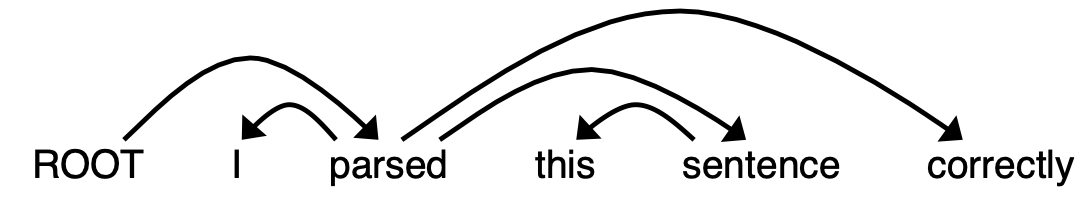

The sequence of transition needed to parse the sentence are as follows: 

| Stack | Buffer| New dependency | Transition |
| --- | --- | --- | --- |
| [ROOT]| [I, parsed, this, sentence, correctly] | |Initial Configuration |
| [ROOT, I]| [parsed, this, sentence, correctly] | |SHIFT |
| [ROOT, I, parsed]| [this, sentence, correctly] | |SHIFT |
| [ROOT, parsed]| [this, sentence, correctly] |parsed --> I |LEFT-ARC |
| [ROOT, parsed, this]| [sentence, correctly] | |SHIFT |
| [ROOT, parsed, this, sentence]| [correctly] | |SHIFT |
| [ROOT, parsed, sentence]| [correctly] | this --> sentence  |LEFT-ARC|
| [ROOT, parsed]| [correctly] | parsed --> sentence  |RIGHT-ARC|
| [ROOT, parsed, correctly]|   |   |SHIFT|
| [ROOT, parsed]|   | parsed --> correctly   |RIGHT-ARC|
| [ROOT]|   | ROOT --> parsed   |RIGHT-ARC|
| [ROOT]|   |    |END|


# Implementation
We are now going to train a neural network to predict, given the state of the stack, buffer, and
dependencies, which transition should be applied next. First, the model extracts a feature vector
representing the current state. We will be using the feature set presented in the original neural
dependency parsing paper: [A Fast and Accurate Dependency Parser using Neural Networks](https://nlp.stanford.edu/pubs/emnlp2014-depparser.pdf). The function extracting these features has been implemented in `utils/parser utils.py` .
This feature vector consists of a list of tokens (e.g., the last word in the stack, first word in the buffer,
dependent of the second-to-last word in the stack if there is one, etc.). They can be represented
as a list of integers $[w_1, w_2, . . . , w_m]$ where $m$ is the number of features and each $0 ≤ w_i < |V|$ is
the index of a token in the vocabulary ($|V|$ is the vocabulary size). First our network looks up an
embedding for each word and concatenates them into a single input vector: 

$$\textbf{x}=[\textbf{E}_{w_1},...,\textbf{E}_{w_m}] \in \mathbb{R}^{dm}$$

where $\textbf{E} \in \mathbb{R} ^ {|V|×d}$ is an embedding matrix with each row $\textbf{E}_w$ as the vector for a particular word $w$. We then compute our predictions as:

$$ \textbf{h} = \text{ReLU} ( \textbf{xW} + \text{b}_1 )$$
$$ \textbf{l} = \textbf{hU} + \text{b}_2$$
$$ \hat{y} = \text{softmax} (l)$$

where $\textbf{h}$ is referred to as the hidden layer, $\textbf{l}$ is referred to as the logits, $ \hat{y}$ is referred to as the
predictions, and $\text{ReLU}(z) = max(z, 0))$. We will train the model to minimize cross-entropy loss:

$$J(\theta) = CE(y,\hat{y}) = - \sum_{i=1}^3 y_i \log \hat{y}_i $$

To compute the loss for the training set, we average this $J(\theta)$ across all training examples.


# Implementation

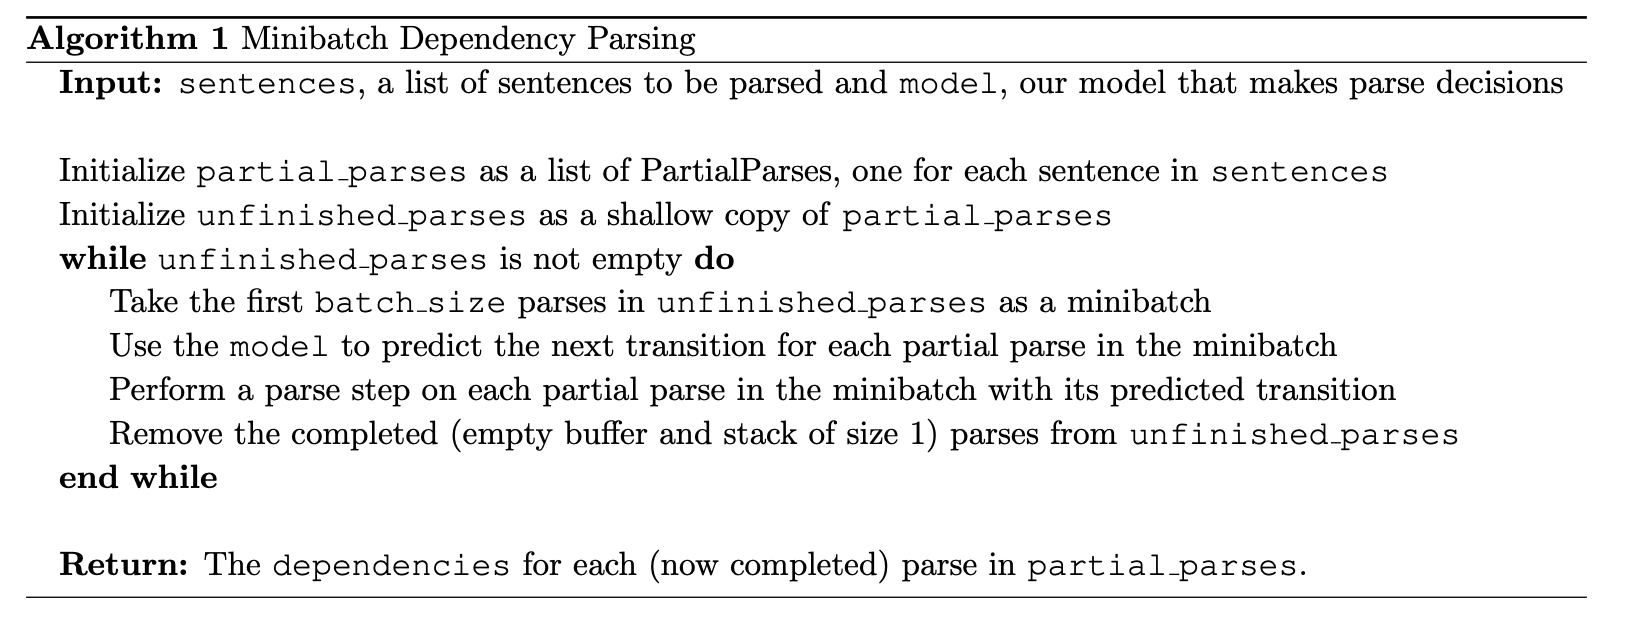

### Libraries

In [8]:
from datetime import datetime
import os
import pickle
import math
import time

from torch import nn, optim
import torch
from tqdm import tqdm

from utils.parser_utils import minibatches, load_and_preprocess_data, AverageMeter

Let's take a glance at the data first:

In [26]:
debug=False
parser, embeddings, train_data, dev_data, test_data = load_and_preprocess_data(debug)

Loading data...
took 1.87 seconds
Building parser...
took 1.12 seconds
Loading pretrained embeddings...
took 2.38 seconds
Vectorizing data...
took 1.52 seconds
Preprocessing training data...
took 40.32 seconds


In [27]:
print('There are %d words in the vocab, and size of embedding vector is %d' %(embeddings.shape[0],embeddings.shape[1]))

There are 39638 words in the vocab, and size of embedding vector is 50


In [72]:
print('There are %d examples in the trianing dataset' %(len(train_data)))

There are 1892336 examples in the trianing dataset


In [29]:
print('There are %d samples in the dev dataset' %(len(dev_data)))

There are 1700 samples in the dev dataset


In [30]:
print('There are %d samples in the trianing dataset' %(len(test_data)))

There are 2416 samples in the trianing dataset


## NN modeuls
Let's implement our feed-forward NN, which we intend to train, as a PyTorch [custom NN module](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html). In PyTorch all neural networks are a subclass of `nn.Module`. We define 3 methods in the class:
- `__init__`: Class constructor,
- `embedding_lookup`: Maps token indexes to word embedding vectors,
- `forward`: Performs a feedforward pass and return `logits` for backprop.

we use Xavier Uniform Initialization for our Weight initialization. It has been shown empirically, that this provides better initial weights for training networks than random uniform initialization. We use a generous Dropout of 50% for regularization.

In [73]:
class ParserModel(nn.Module):
    """ Feedforward neural network with an embedding layer and single hidden layer.
    The ParserModel will predict which transition should be applied to a
    given partial parse configuration.
    """
    def __init__(self, embeddings, n_features=36,
        hidden_size=200, n_classes=3, dropout_prob=0.5):
        
        super(ParserModel, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size = embeddings.shape[1]
        self.hidden_size = hidden_size
        
        self.pretrained_embeddings = nn.Embedding(embeddings.shape[0], self.embed_size)
        self.pretrained_embeddings.weight = nn.Parameter(torch.tensor(embeddings))
        self.embed_to_hidden=nn.Linear(self.n_features*self.embed_size,self.hidden_size)
        nn.init.xavier_uniform_(self.embed_to_hidden.weight)
        self.dropout=nn.Dropout(self.dropout_prob)
        self.hidden_to_logits=nn.Linear(self.hidden_size,self.n_classes)
        nn.init.xavier_uniform_(self.hidden_to_logits.weight)

    def embedding_lookup(self, t):
        """ Utilize `self.pretrained_embeddings` to map input `t` from input tokens (integers)
            to embedding vectors.

            @param t (Tensor): input tensor of tokens (batch_size, n_features)

            @return x (Tensor): tensor of embeddings for words represented in t
                                (batch_size, n_features * embed_size)
        """
        x_raw=self.pretrained_embeddings(t)
        batch_size=x_raw.shape[0]
        x=x_raw.view(batch_size,self.n_features*self.embed_size)
 
        return x


    def forward(self, t):
        """ Run the model forward.

        @param t (Tensor): input tensor of tokens (batch_size, n_features)

        @return logits (Tensor): tensor of predictions (output after applying the layers of the network)
                                 without applying softmax (batch_size, n_classes)
        """
        embds=self.embedding_lookup(t)
        out=self.embed_to_hidden(embds)
        out=F.relu(out)
        out=self.dropout(out)
        logits=self.hidden_to_logits(out)
 
        return logits

Define `train_for_epoch` which runs the model for a single epoch, evaluates the model on dev set and return the Unlabeled Attachment Score (UAS) score: 

In [76]:
def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size):
    """ Train the neural dependency parser for single epoch.

    @param parser (Parser): Neural Dependency Parser
    @param train_data ():
    @param dev_data ():
    @param optimizer (nn.Optimizer): Adam Optimizer
    @param loss_func (nn.CrossEntropyLoss): Cross Entropy Loss Function
    @param batch_size (int): batch size
    @param lr (float): learning rate

    @return dev_UAS (float): Unlabeled Attachment Score (UAS) for dev data
    """
    parser.model.train() # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
            optimizer.zero_grad()   # remove any baggage in the optimizer
            loss = 0. # store loss for this batch here
            train_x = torch.from_numpy(train_x).long()
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()
            logits=parser.model(train_x)
            loss=loss_func(logits,train_y)
            loss.backward()
            optimizer.step()
            
            prog.update(1)
            loss_meter.update(loss.item())

    print ("Average Train Loss: {}".format(loss_meter.avg))

    print("Evaluating on dev set",)
    parser.model.eval() # Places model in "eval" mode, i.e. don't apply dropout layer
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

Now define the `train` function which constructs the optimizer and cross-entropy loss functions and trains the model:

In [77]:
def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005):
    """ Train the neural dependency parser.

    @param parser (Parser): Neural Dependency Parser
    @param train_data ():
    @param dev_data ():
    @param output_path (str): Path to which model weights and results are written.
    @param batch_size (int): Number of examples in a single batch
    @param n_epochs (int): Number of training epochs
    @param lr (float): Learning rate
    """
    best_dev_UAS = 0
    optimizer=optim.Adam(parser.model.parameters(), lr=lr)
    loss_func=nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")

## Showtime: training!

Now let's instantiate the `nn.module` that we just defined with pre-defined word embeddings that we loaded above:

In [87]:
model = ParserModel(embeddings)

Now assign the `model` to `parser`:

In [88]:
parser.model = model

After each epoch, model evaluates the UAS score on the dev set, and if it has improved from the last epoch it will save the model in the following path:

In [89]:
output_dir = "results/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
startTime = time.time()
train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005)
print("took %d minutes\n" %((time.time() - startTime)/60))

## Final evaluation

The model in the original neural dependency parsing paper gets 92.5 UAS, let's see how we did:

In [86]:
parser.model.eval()
UAS, dependencies = parser.parse(test_data)
print(UAS)

0.8909568837767271